# Imports

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns

from datetime import datetime
from pandas import read_csv

from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from libraries.time_series_tutorials import evaluate_arima_model_wf, evaluate_arima_model, grid_search_arima, grid_search_arima_wf 
from libraries.time_series_tutorials import exp_smoothing_forecast, evaluate_es_model, exp_smoothing_configs, evaluate_es_model_wf
from libraries.time_series_tutorials import score_model, score_model_wf, grid_search_es, grid_search_es_wf

from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

from warnings import catch_warnings
from warnings import filterwarnings

from numpy import array

from matplotlib import pyplot

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

In [27]:
df = pd.read_csv('monthly-car-sales.csv')

In [28]:
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [29]:
df['Month'] = pd.to_datetime(df['Month'])

In [30]:
df = df.set_index('Month')

In [31]:
series = df.squeeze()

In [32]:
series

Month
1960-01-01     6550
1960-02-01     8728
1960-03-01    12026
1960-04-01    14395
1960-05-01    14587
1960-06-01    13791
1960-07-01     9498
1960-08-01     8251
1960-09-01     7049
1960-10-01     9545
1960-11-01     9364
1960-12-01     8456
1961-01-01     7237
1961-02-01     9374
1961-03-01    11837
1961-04-01    13784
1961-05-01    15926
1961-06-01    13821
1961-07-01    11143
1961-08-01     7975
1961-09-01     7610
1961-10-01    10015
1961-11-01    12759
1961-12-01     8816
1962-01-01    10677
1962-02-01    10947
1962-03-01    15200
1962-04-01    17010
1962-05-01    20900
1962-06-01    16205
1962-07-01    12143
1962-08-01     8997
1962-09-01     5568
1962-10-01    11474
1962-11-01    12256
1962-12-01    10583
1963-01-01    10862
1963-02-01    10965
1963-03-01    14405
1963-04-01    20379
1963-05-01    20128
1963-06-01    17816
1963-07-01    12268
1963-08-01     8642
1963-09-01     7962
1963-10-01    13932
1963-11-01    15936
1963-12-01    12628
1964-01-01    12267
1964-02-01    

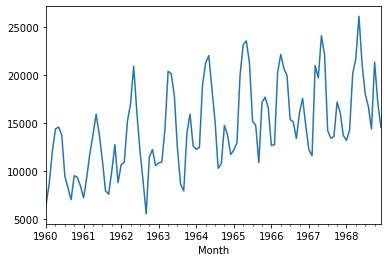

In [83]:
series.plot();

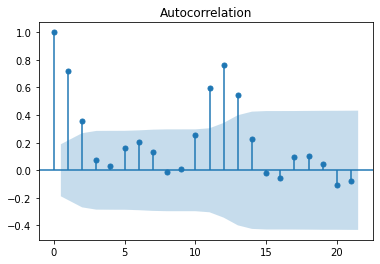

In [35]:
plot_acf(series);

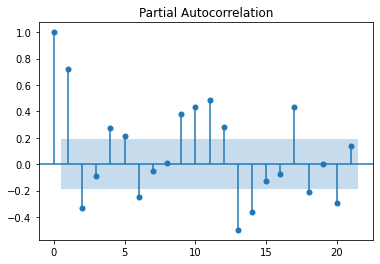

In [36]:
plot_pacf(series);

In [37]:
model = ARIMA(series, order=(15,1,0))
model_fit = model.fit()

In [38]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  108
Model:                ARIMA(15, 1, 0)   Log Likelihood                -946.308
Date:                Mon, 02 May 2022   AIC                           1924.617
Time:                        20:46:00   BIC                           1967.382
Sample:                    01-01-1960   HQIC                          1941.953
                         - 12-01-1968                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6101      0.098     -6.220      0.000      -0.802      -0.418
ar.L2         -0.3623      0.105     -3.447      0.001      -0.568      -0.156
ar.L3         -0.3931      0.113     -3.483      0.0

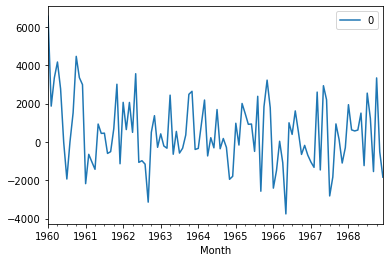

In [39]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

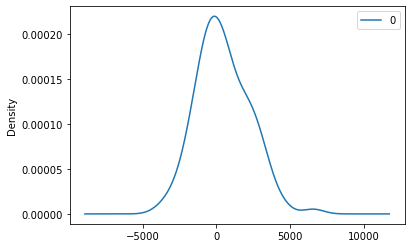

In [40]:
residuals.plot(kind='kde')
pyplot.show()

In [41]:
print(residuals.describe())

                 0
count   108.000000
mean    449.015067
std    1786.242673
min   -3755.358991
25%    -662.782884
50%     374.808610
75%    1709.250772
max    6550.000000


In [45]:
yearly_sum = series.values

# Creating our holdout test set

series_train = yearly_sum[:(len(yearly_sum) - 24)]
series_test = yearly_sum[(len(yearly_sum) - 24):]

In [46]:
series_train

array([ 6550,  8728, 12026, 14395, 14587, 13791,  9498,  8251,  7049,
        9545,  9364,  8456,  7237,  9374, 11837, 13784, 15926, 13821,
       11143,  7975,  7610, 10015, 12759,  8816, 10677, 10947, 15200,
       17010, 20900, 16205, 12143,  8997,  5568, 11474, 12256, 10583,
       10862, 10965, 14405, 20379, 20128, 17816, 12268,  8642,  7962,
       13932, 15936, 12628, 12267, 12470, 18944, 21259, 22015, 18581,
       15175, 10306, 10792, 14752, 13754, 11738, 12181, 12965, 19990,
       23125, 23541, 21247, 15189, 14767, 10895, 17130, 17697, 16611,
       12674, 12760, 20249, 22135, 20677, 19933, 15388, 15113, 13401,
       16135, 17562, 14720])

In [47]:
series_test

array([12225, 11608, 20985, 19692, 24081, 22114, 14220, 13434, 13598,
       17187, 16119, 13713, 13210, 14251, 20139, 21725, 26099, 21084,
       18024, 16722, 14385, 21342, 17180, 14577])

In [48]:
history = [x for x in series_train]
predictions = list()

In [49]:
for step in range(len(series_test)):
    model = ARIMA(history, order=(15,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_pred = output[0]
    predictions.append(y_pred)
    history.append(y_pred)

In [50]:
predictions = np.array(predictions)

In [51]:
predictions

array([13121.59664085, 12987.31673041, 19467.59311976, 21239.61539557,
       20650.25518592, 19074.89374788, 15574.61932918, 14649.21948961,
       14198.4739939 , 15719.16623162, 17258.2032805 , 14687.17868547,
       13112.5076628 , 13896.34580161, 18485.14046286, 21193.71701642,
       20298.94491977, 18891.04336657, 15551.9781384 , 14714.30404043,
       14559.18876835, 15772.82211466, 16915.24823319, 14750.18038742])

In [52]:
series_test

array([12225, 11608, 20985, 19692, 24081, 22114, 14220, 13434, 13598,
       17187, 16119, 13713, 13210, 14251, 20139, 21725, 26099, 21084,
       18024, 16722, 14385, 21342, 17180, 14577])

In [53]:
math.sqrt(mean_squared_error(series_test, predictions))

2230.2305409246123

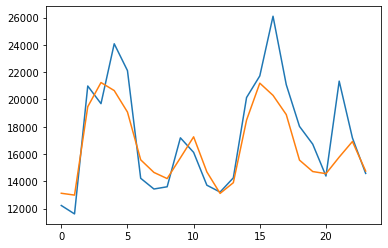

In [54]:

pyplot.plot(series_test)
pyplot.plot(predictions)
pyplot.show()

In [57]:
adfuller(residuals)[1].round()

0.0

In [58]:
arima_order = (15,1,0)

In [59]:
rmse = evaluate_arima_model(series, 12, arima_order)

In [60]:
rmse

2460.8161980542004

In [61]:
p_values = [0, 4, 8, 12, 16, 20]
d_values = range(0, 3)
q_values = range(0, 3)

In [62]:
grid_search_arima(series, 12, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=5542.648
ARIMA(0, 0, 1) RMSE=5541.923
ARIMA(0, 0, 2) RMSE=5556.823
ARIMA(0, 1, 0) RMSE=5865.374
ARIMA(0, 1, 1) RMSE=6198.792
ARIMA(0, 1, 2) RMSE=7477.905
ARIMA(0, 2, 0) RMSE=22035.574
ARIMA(0, 2, 1) RMSE=5256.884
ARIMA(0, 2, 2) RMSE=5619.021
ARIMA(4, 0, 0) RMSE=5526.650
ARIMA(4, 0, 1) RMSE=5492.088
ARIMA(4, 0, 2) RMSE=5528.947
ARIMA(4, 1, 0) RMSE=5667.528
ARIMA(4, 1, 1) RMSE=5688.369
ARIMA(4, 1, 2) RMSE=5685.161
ARIMA(4, 2, 0) RMSE=10835.836
ARIMA(4, 2, 1) RMSE=6690.190
ARIMA(4, 2, 2) RMSE=4994.725
ARIMA(8, 0, 0) RMSE=5497.201
ARIMA(8, 0, 1) RMSE=5687.609
ARIMA(8, 0, 2) RMSE=5782.577
ARIMA(8, 1, 0) RMSE=3524.490
ARIMA(8, 1, 1) RMSE=2286.442
ARIMA(8, 1, 2) RMSE=2395.385
ARIMA(8, 2, 0) RMSE=14842.192
ARIMA(8, 2, 1) RMSE=3198.216
ARIMA(8, 2, 2) RMSE=2646.885
ARIMA(12, 0, 0) RMSE=2117.721
ARIMA(12, 0, 1) RMSE=2064.028
ARIMA(12, 0, 2) RMSE=2185.537
ARIMA(12, 1, 0) RMSE=2127.178
ARIMA(12, 1, 1) RMSE=2217.858
ARIMA(12, 1, 2) RMSE=2216.205
ARIMA(12, 2, 0) RMSE=3243.788
ARIM

In [63]:
grid_search_arima_wf(series, 12, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=5399.261
ARIMA(0, 0, 1) RMSE=4059.811
ARIMA(0, 0, 2) RMSE=3642.383
ARIMA(0, 1, 0) RMSE=3783.966
ARIMA(0, 1, 1) RMSE=3929.179
ARIMA(0, 1, 2) RMSE=3915.038
ARIMA(0, 2, 0) RMSE=5510.272
ARIMA(0, 2, 1) RMSE=3802.108
ARIMA(0, 2, 2) RMSE=3961.650
ARIMA(4, 0, 0) RMSE=3552.318
ARIMA(4, 0, 1) RMSE=3515.756
ARIMA(4, 0, 2) RMSE=2902.372
ARIMA(4, 1, 0) RMSE=3395.067
ARIMA(4, 1, 1) RMSE=3095.091
ARIMA(4, 1, 2) RMSE=3093.715
ARIMA(4, 2, 0) RMSE=3285.473
ARIMA(4, 2, 1) RMSE=3329.092
ARIMA(4, 2, 2) RMSE=3152.787
ARIMA(8, 0, 0) RMSE=3058.299
ARIMA(8, 0, 1) RMSE=3071.920
ARIMA(8, 0, 2) RMSE=3133.290
ARIMA(8, 1, 0) RMSE=2628.817
ARIMA(8, 1, 1) RMSE=2211.794
ARIMA(8, 1, 2) RMSE=1983.875
ARIMA(8, 2, 0) RMSE=3312.979
ARIMA(8, 2, 1) RMSE=2735.584
ARIMA(8, 2, 2) RMSE=2285.169
ARIMA(12, 0, 0) RMSE=1859.177
ARIMA(12, 0, 1) RMSE=1763.262
ARIMA(12, 0, 2) RMSE=1903.278
ARIMA(12, 1, 0) RMSE=1714.368
ARIMA(12, 1, 1) RMSE=1674.334
ARIMA(12, 1, 2) RMSE=1683.206
ARIMA(12, 2, 0) RMSE=1954.537
ARIMA(1

In [64]:
history = [x for x in series_train]
predictions = list()

In [65]:
for step in range(len(series_test)):
    model = ARIMA(history, order=(16,2,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_pred = output[0]
    predictions.append(y_pred)
    history.append(y_pred)

In [66]:
predictions = np.array(predictions)

In [67]:
predictions

array([13894.54579007, 12982.34185536, 19992.83396922, 22037.80286097,
       22308.7698906 , 20334.22611125, 16034.11227591, 15639.36868273,
       15327.37069068, 16807.15972634, 17954.34802912, 15278.35226327,
       14381.37302936, 14510.0112977 , 19292.71308959, 22846.75549812,
       22447.98821899, 21033.1480064 , 16309.33163267, 16404.39313545,
       16404.81570868, 17745.38020415, 18452.84392617, 15861.1142489 ])

In [68]:
math.sqrt(mean_squared_error(series_test, predictions))

1763.6591658633984

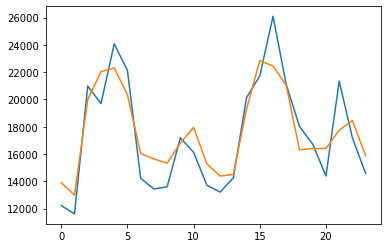

In [69]:
pyplot.plot(series_test)
pyplot.plot(predictions)
pyplot.show()

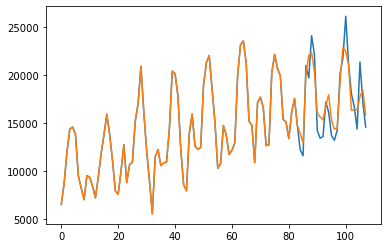

In [70]:
pyplot.plot(yearly_sum)
pyplot.plot(history)
pyplot.show()

In [72]:
history = [x for x in series_train]
predictions = list()

In [73]:
for step in range(len(series_test)):
    model = ExponentialSmoothing(history, trend='mul')
    model_fit = model.fit(optimized=True)
    output = model_fit.forecast()
    y_pred = output[0]
    predictions.append(y_pred)
    history.append(y_pred)

In [74]:
predictions = np.array(predictions)

In [75]:
math.sqrt(mean_squared_error(series_test, predictions))

4206.782838634758

In [93]:
history = [x for x in series_train]
predictions = list()

In [94]:
first_pred = series_train[(len(series_train) - 1)]
predictions.append(first_pred)

for step in range(len(series_test) - 1):
    y_pred = series_test[step]
    predictions.append(y_pred)

In [95]:
predictions = np.array(predictions)

In [96]:
math.sqrt(mean_squared_error(series_test, predictions))

3947.1995188572196